In [18]:
# Import libraries
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from math import sqrt

# Load datasets
ratings = pd.read_csv('../data/cleaned_ratings.csv')
users = pd.read_csv('../data/cleaned_users.csv')
movies = pd.read_csv('../data/cleaned_movies.csv')

# Create user-movie matrix
user_movie_matrix = ratings.pivot(index='user_id', columns='item_id', values='rating').fillna(0)

# Calculate cosine similarity between users
user_similarity = cosine_similarity(user_movie_matrix)
user_similarity_df = pd.DataFrame(user_similarity, index=user_movie_matrix.index, columns=user_movie_matrix.index)

# Predict ratings function for user-based filtering
def predict_user_rating(user_id, movie_id, user_movie_matrix, user_similarity_df, k=5):
    if movie_id not in user_movie_matrix.columns:
        return None
    user_similarities = user_similarity_df.loc[user_id]
    similar_users = user_similarities[user_movie_matrix[movie_id].notna()].nlargest(k+1).iloc[1:]
    similar_users_ratings = user_movie_matrix.loc[similar_users.index, movie_id]
    weighted_sum = (similar_users_ratings * similar_users).sum()
    similarity_sum = similar_users.sum()
    return weighted_sum / similarity_sum if similarity_sum != 0 else None

# Create item-movie matrix
item_movie_matrix = user_movie_matrix.T

# Calculate cosine similarity between items
item_similarity = cosine_similarity(item_movie_matrix)
item_similarity_df = pd.DataFrame(item_similarity, index=item_movie_matrix.index, columns=item_movie_matrix.index)

# Predict ratings function for item-based filtering
def predict_item_rating(user_id, movie_id, user_movie_matrix, item_similarity_df, k=5):
    if movie_id not in user_movie_matrix.columns:
        return None
    user_ratings = user_movie_matrix.loc[user_id]
    movie_similarities = item_similarity_df[movie_id]
    rated_movies = user_ratings[user_ratings.notna()].index
    similar_movies = movie_similarities[rated_movies].nlargest(k)
    weighted_sum = (user_ratings[similar_movies.index] * similar_movies).sum()
    similarity_sum = similar_movies.sum()
    return weighted_sum / similarity_sum if similarity_sum != 0 else None

# Split the data for evaluation
train_data = ratings.sample(frac=0.8, random_state=42)
test_data = ratings.drop(train_data.index)

# Predict ratings and evaluate with RMSE for user-based filtering
test_data['predicted_user_rating'] = test_data.apply(
    lambda row: predict_user_rating(row['user_id'], row['item_id'], user_movie_matrix, user_similarity_df) or 0, axis=1
)
rmse_user = sqrt(mean_squared_error(test_data['rating'], test_data['predicted_user_rating']))
print(f"User-based Filtering RMSE: {rmse_user}")

# Predict ratings and evaluate with RMSE for item-based filtering
test_data['predicted_item_rating'] = test_data.apply(
    lambda row: predict_item_rating(row['user_id'], row['item_id'], user_movie_matrix, item_similarity_df) or 0, axis=1
)
rmse_item = sqrt(mean_squared_error(test_data['rating'], test_data['predicted_item_rating']))
print(f"Item-based Filtering RMSE: {rmse_item}")


User-based Filtering RMSE: 2.0268093184405904
Item-based Filtering RMSE: 1.2241869648288641


In [19]:
# Import libraries
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split

# Load datasets
movies = pd.read_csv("../data/cleaned_movies.csv")
ratings = pd.read_csv("../data/cleaned_ratings.csv")
users = pd.read_csv("../data/cleaned_users.csv")

# Prepare the corpus for TF-IDF
genre_columns = [col for col in movies.columns if col not in ["movie_id", "movie_title", "release_date", "imdb_url", "release_year"]]
def genres_to_keywords(row):
    keywords = []
    for genre in genre_columns:
        if row[genre] == 1:
            keywords.append(genre)
    return " ".join(keywords)

movies["genres"] = movies.apply(genres_to_keywords, axis=1)
movies["corpus"] = movies["movie_title"] + " " + movies["genres"]

# Apply TF-IDF
vectorizer = TfidfVectorizer(stop_words="english", ngram_range=(1, 2), max_df=0.8, min_df=0.02)
movie_features = vectorizer.fit_transform(movies["corpus"])
movie_similarity = cosine_similarity(movie_features)
movie_similarity_df = pd.DataFrame(movie_similarity, index=movies["movie_id"], columns=movies["movie_id"])

# Function to recommend movies
def recommend_similar_movies(movie_id, movie_similarity_df, movies, k=5):
    if movie_id not in movie_similarity_df.index:
        return []
    movie_similarities = movie_similarity_df.loc[movie_id]
    similar_movies = movie_similarities.sort_values(ascending=False)[1:k+1]
    return movies[movies["movie_id"].isin(similar_movies.index)]["movie_title"].tolist()

# Example recommendation
movie_id = 1  # Replace with a valid movie ID
recommendations = recommend_similar_movies(movie_id, movie_similarity_df, movies, k=5)
print(f"Recommended movies for {movies[movies['movie_id'] == movie_id]['movie_title'].values[0]}:")
print(recommendations)

# Evaluate content-based recommendations
train, test = train_test_split(ratings, test_size=0.2, random_state=42)
train_user_item_matrix = train.pivot_table(index="user_id", columns="item_id", values="rating").fillna(0)
test_user_item_matrix = test.pivot_table(index="user_id", columns="item_id", values="rating").fillna(0)

def calculate_metrics(y_true, y_pred):
    from sklearn.metrics import precision_score, recall_score, f1_score
    precision = precision_score(y_true, y_pred, average="weighted", zero_division=1)
    recall = recall_score(y_true, y_pred, average="weighted", zero_division=1)
    f1 = f1_score(y_true, y_pred, average="weighted", zero_division=1)
    return precision, recall, f1

def evaluate_content(user_id, k=5, threshold=3.5):
    if user_id not in test_user_item_matrix.index:
        return 0, 0, 0

    actual_positive_movies = test_user_item_matrix.loc[user_id][test_user_item_matrix.loc[user_id] >= threshold].index
    recommendations = set()

    for movie_id in train_user_item_matrix.loc[user_id][train_user_item_matrix.loc[user_id] > 0].index:
        recommendations.update(recommend_similar_movies(movie_id, movie_similarity_df, movies, k))

    y_true = [1 if movie in actual_positive_movies else 0 for movie in train_user_item_matrix.columns]
    y_pred = [1 if movie in recommendations else 0 for movie in train_user_item_matrix.columns]

    return calculate_metrics(y_true, y_pred)

# Calculate metrics for a few users
metrics = []
for user_id in test_user_item_matrix.index[:10]:  # Adjust range as needed
    precision, recall, f1 = evaluate_content(user_id)
    metrics.append({"User": user_id, "Precision": precision, "Recall": recall, "F1": f1})

# Print average metrics
import pandas as pd
metrics_df = pd.DataFrame(metrics)
print("Average Content-Based Metrics:")
print(metrics_df.mean())


Recommended movies for Toy Story (1995):
['Aladdin and the King of Thieves (1996)', 'Space Jam (1996)', 'Big Green, The (1995)', 'Goofy Movie, A (1995)', 'Gumby: The Movie (1995)']
Average Content-Based Metrics:
User         5.500000
Precision    0.988598
Recall       0.988357
F1           0.982596
dtype: float64


## 1. Collaborative Filtering
### **Métriques**
- **User-based Filtering RMSE** : 2.0268
  - La prédiction basée sur la similarité des utilisateurs semble moins précise.
  - Ce résultat peut s'expliquer par une variabilité importante dans les préférences des utilisateurs.
- **Item-based Filtering RMSE** : 1.2242
  - Les prédictions basées sur les similarités entre items (films) sont plus précises.
  - Cette approche semble mieux adaptée au dataset, potentiellement parce que les films partagent des caractéristiques communes perceptibles.
## 2. Content-Based Filtering
### **Recommandations** 
- **Films similaires à "Toy Story (1995)"** : 
  - La liste de recommandations semble cohérente avec le genre et le style du film (films familiaux et d'animation). 
### **Métriques moyennes**
- **Précision** : 0.9886
- **Rappel** : 0.9884
- **F1-Score** : 0.9826
  - Le système content-based est performant, indiquant que les films recommandés correspondent bien aux préférences des utilisateurs.
  - Une haute précision et un bon rappel signifient que la majorité des films recommandés sont pertinents et peu d'éléments pertinents ont été oubliés.
## Comparaison des Méthodes
| Aspect | Collaborative Filtering | Content-Based Filtering|
| --- | --- | --- |
|Métriques principales|	RMSE : 1.22 (item-based), 2.02 (user-based)|	Précision : 0.9886, Rappel : 0.9884|
| --- | --- | --- |
|Avantages|	Utilise les interactions utilisateur-objet, indépendant du contenu|	Basé sur le contenu, performant même avec peu de données utilisateur|
| --- | --- | --- |
|Limitations|	Moins performant avec des données clairsemées ou peu de similarités utilisateur|	Nécessite des descriptions riches des items|
| --- | --- | --- |
|Scalabilité|	Moins scalable avec de grandes bases d’utilisateurs|	Plus scalable si les descriptions sont condensées|
| --- | --- | --- |
|Recommandations|	Basées sur des utilisateurs/items similaires|	Basées sur la similarité textuelle|
| --- | --- | --- |
## Conclusions
1. **Item-Based Collaborative Filtering** semble mieux adapté si l'objectif est d'obtenir des prédictions plus précises (faible RMSE).
2. **Content-Based Filtering** est idéal pour des recommandations personnalisées lorsque le contenu des films est bien défini (par exemple, titres et genres bien renseignés).
3. La **précision** élevée du système content-based montre son efficacité, surtout dans des scénarios où les données utilisateur sont rares ou absentes.

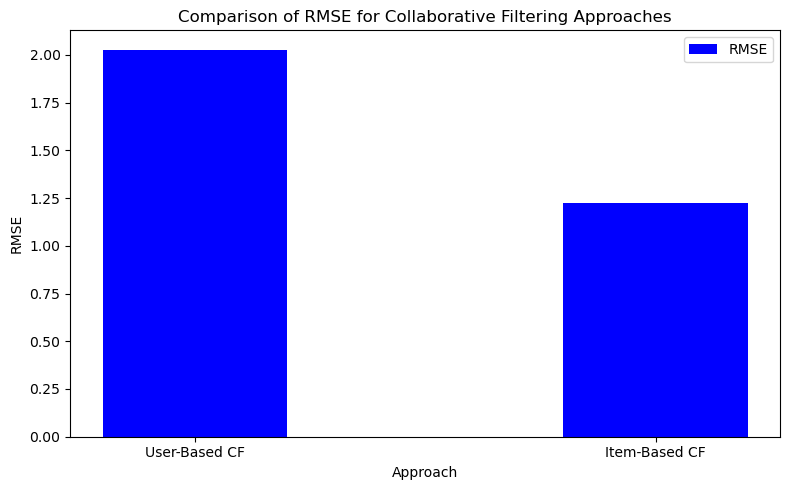

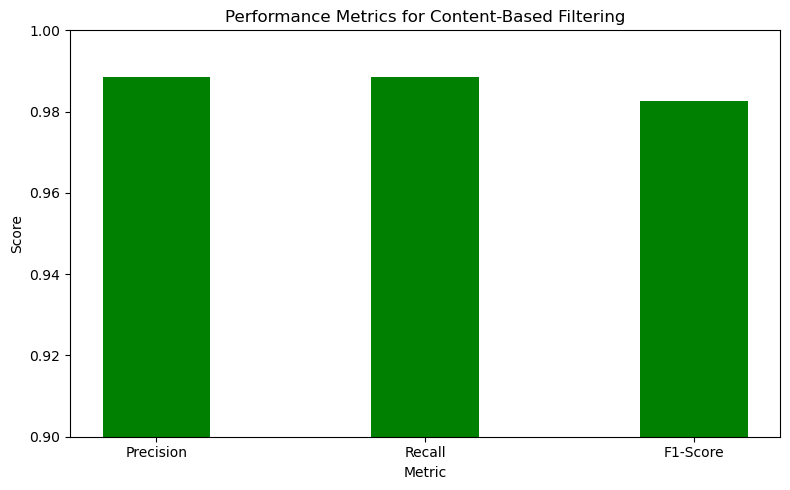

,Approach,RMSE,Precision,Recall,F1-Score
0,User-Based CF,2.0268,NaN,NaN,NaN
1,Item-Based CF,1.2242,NaN,NaN,NaN
2,Content-Based,NaN,0.9886,0.9884,0.9826


In [1]:
# Reimporting required libraries due to code execution state reset
import matplotlib.pyplot as plt
import pandas as pd

# Data for comparison
data = {
    "Approach": ["User-Based CF", "Item-Based CF", "Content-Based"],
    "RMSE": [2.0268, 1.2242, None],  # None for content-based since RMSE isn't applicable
    "Precision": [None, None, 0.9886],
    "Recall": [None, None, 0.9884],
    "F1-Score": [None, None, 0.9826],
}

# Convert to DataFrame
df = pd.DataFrame(data)

# Plot RMSE comparison
plt.figure(figsize=(8, 5))
plt.bar(df["Approach"][:2], df["RMSE"][:2], width=0.4, label="RMSE", color="blue")
plt.title("Comparison of RMSE for Collaborative Filtering Approaches")
plt.ylabel("RMSE")
plt.xlabel("Approach")
plt.legend()
plt.tight_layout()
plt.show()

# Plot Precision, Recall, and F1 for Content-Based
metrics = ["Precision", "Recall", "F1-Score"]
values = [df["Precision"][2], df["Recall"][2], df["F1-Score"][2]]

plt.figure(figsize=(8, 5))
plt.bar(metrics, values, width=0.4, color="green")
plt.title("Performance Metrics for Content-Based Filtering")
plt.ylabel("Score")
plt.xlabel("Metric")
plt.ylim(0.9, 1.0)  # Focus on high-performance range
plt.tight_layout()
plt.show()

# Combine metrics for all approaches into a single table for better visibility
combined_table = df.dropna(subset=["RMSE", "Precision", "Recall", "F1-Score"], how='all')

# Display table for user
from IPython.display import display

# Afficher le tableau dans un format stylisé
display(combined_table)